In [1]:
from collections import defaultdict

import networkx as nx

graph = nx.read_gml('c:/Users/rodrigo/github/hyphy/datasets/karate.gml')
cliques = list(nx.find_cliques(graph))

In [4]:
from phoenix.helpers import *
from phoenix.SortedKeyCollections import *

models = phoenix.compress(cliques)

In [7]:
powergrid_clq_num_dist = normalize_distribution(clique_number_distribution(cliques))

In [47]:
powergrid_clq_num_dist

Counter({2: 0.3055555555555556,
         3: 0.5833333333333334,
         4: 0.05555555555555555,
         5: 0.05555555555555555})

In [8]:
powergrid_clq_x_clq_distribution = normalize_distributions(cliques_x_cliques_distribution(cliques))

In [18]:
powergrid_clq_x_clq_distribution = helpers.normalize_distributions(helpers.cliques_x_cliques_distribution(cliques))
powergrid_clq_x_clq_distribution

{(2, 2): Counter({0: 0.8363636363636363, 1: 0.16363636363636364}),
 (2, 3): Counter({0: 0.7229437229437229, 1: 0.27705627705627706}),
 (2, 4): Counter({0: 0.6363636363636364, 1: 0.36363636363636365}),
 (2, 5): Counter({0: 0.4090909090909091, 1: 0.5909090909090909}),
 (3, 3): Counter({0: 0.6, 1: 0.28095238095238095, 2: 0.11904761904761904}),
 (3, 4): Counter({0: 0.5, 1: 0.14285714285714285, 2: 0.35714285714285715}),
 (3,
  5): Counter({0: 0.5238095238095238,
          1: 0.23809523809523808,
          2: 0.23809523809523808}),
 (4, 4): Counter({2: 1.0}),
 (4, 5): Counter({0: 1.0}),
 (5, 5): Counter({4: 1.0})}

In [ ]:
kl_divergence(powergrid_clq_num_dist, {2: 0.5, 3: 0.5})

In [490]:
from random import sample
from itertools import combinations

def decompress(clq_num_dist, clq_x_clq_dist, node_count, kl_threshold, iteration_cap=100, debug=False):
    
    """In the greedy step (decision process), we choose the operation
    that most minimizes the kl divergence."""
    nodes = list(range(node_count))
    ### Initialize clqs with a clique of random selected size 
    clqs = []
    clq_size = get_weighted_random_value(clq_num_dist)
    clq_nodes = sample(nodes, clq_size)
    clqs.append(clq_nodes)
    ### Initialize hypergraph's distributions
    ref_clq_num_dist = normalize_distribution(clique_number_distribution(clqs))
    ref_clq_x_clq_dist = normalize_distributions(cliques_x_cliques_distribution(clqs))
    ### Initialize kl divergence scores
    clq_num_kl = 100 
    clq_x_clq_kl = 100
    avg_kl = (clq_num_kl+clq_x_clq_kl)/2
    ###
    i = 0
    while avg_kl > kl_threshold and i < iteration_cap:
        
        # climb down from arbitrarily high KL value
        min_clq_num_kl = 100
        min_clq_x_clq_kl = 100
        min_clq = []
        
        ### Greedy Decision Process (GDP) ###
        for r in range(1, node_count+1):
            # not-fully exhaustive; exhaustive becomes O(N!)
            random_clq_of_size_r = sample(list(combinations(nodes, r)), 1)
            assert len(random_clq_of_size_r[0]) > 0
            
            # update dists to represent one step forward
            new_clq_num_dist = normalize_distribution(clique_number_distribution(clqs+random_clq_of_size_r))
            new_clq_x_clq_dist = normalize_distributions(cliques_x_cliques_distribution(clqs+random_clq_of_size_r))
            
            # calculate the kl divergences of next step
            kl_1 = kl_divergence(clq_num_dist, new_clq_num_dist)
            kl_2 = avg_kl_divergence(clq_x_clq_dist, new_clq_x_clq_dist)
            
            ## king of the valley(?)-type of minimization
            if (kl_1 < min_clq_num_kl and
                kl_2 < min_clq_x_clq_kl):
                
                min_clq_num_kl = kl_1
                min_clq_x_clq_kl = kl_2
                min_clq = random_clq_of_size_r
        ######### End of GDP ########
        ### Update list of cliques, reference models, and average KL score
        if min_clq and min_clq[0] not in clqs:
            clqs.append(list(min_clq[0]))
        
            ref_clq_num_dist = normalize_distribution(clique_number_distribution(clqs))
            ref_clq_x_clq_dist = normalize_distributions(cliques_x_cliques_distribution(clqs))
            
            clq_num_kl = min_clq_num_kl
            clq_x_clq_kl = min_clq_x_clq_kl
            
            assert clq_num_kl == kl_divergence(clq_num_dist, ref_clq_num_dist)
            assert clq_x_clq_kl == avg_kl_divergence(clq_x_clq_dist, ref_clq_x_clq_dist)
            
            avg_kl = (clq_num_kl+clq_x_clq_kl)/2

            if debug:
                print("iteration:", i)
                print("kl divergence of clique number distributions:", clq_num_kl)
                print("kl divergence of cliqueXclique distributions:", clq_x_clq_kl)
                print()
        i += 1
        
    return clqs

In [ ]:
def get_edges_from_clique(nodes):
    from itertools import combinations
    return list(combinations(nodes, 2))

iteration: 0
kl divergence of clique number distributions: 3.0451042891402964
kl divergence of cliqueXclique distributions: 36.84136148790473

iteration: 1
kl divergence of clique number distributions: 0.043692120681965735
kl divergence of cliqueXclique distributions: 9.210340371976182

iteration: 2
kl divergence of clique number distributions: 0.19274475702175747
kl divergence of cliqueXclique distributions: 4.778456981128077

iteration: 3
kl divergence of clique number distributions: 0.13862943611198905
kl divergence of cliqueXclique distributions: 3.8803019993928176

iteration: 4
kl divergence of clique number distributions: 0.043692120681965735
kl divergence of cliqueXclique distributions: 1.6788977648885874

iteration: 5
kl divergence of clique number distributions: 0.03565675726595824
kl divergence of cliqueXclique distributions: 0.17629838235797576



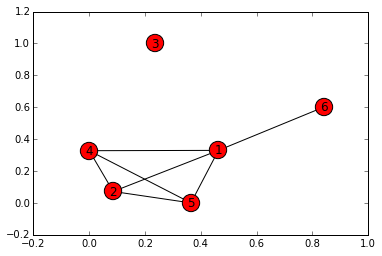

In [489]:
new_clqs = decompress(clq_num_dist, clq_x_clq_dist, 7, 0.5, iteration_cap=50, debug=True)
new_edges = [edge for clq in new_clqs for edge in get_edges_from_clique(clq)]
new_singletons = [node[0] for node in new_clqs if len(node)==1]
new_graph = nx.Graph(new_edges)
new_graph.add_nodes_from(new_singletons)
nx.draw_networkx(new_graph)

In [424]:
clq_num_dist

Counter({1: 0.2, 2: 0.4, 3: 0.4})

[[1, 2, 0], [1, 2, 3], [1, 4], [5], [6, 2]]

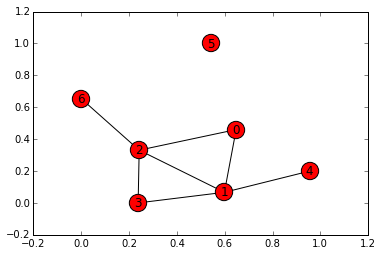

In [425]:
%matplotlib inline
#clqs = [[0,1], [1,2], [2,3], [0,2,4], [5]]
graph = nx.Graph([[0,1], [1,2], [2,3], [1,3], [1,4], [2,6], [0,2]])
graph.add_node(5)
clqs = list(nx.find_cliques(graph))
nx.draw_networkx(graph)
clqs

In [ ]:
nx.draw_networkx()

In [426]:
clq_num_dist = normalize_distribution(clique_number_distribution(clqs))
clq_num_dist

Counter({1: 0.2, 2: 0.4, 3: 0.4})

In [427]:
clq_x_clq_dist = normalize_distributions(cliques_x_cliques_distribution(clqs))
clq_x_clq_dist

{(1, 2): Counter({0: 1.0}),
 (1, 3): Counter({0: 1.0}),
 (2, 2): Counter({0: 1.0}),
 (2, 3): Counter({1: 1.0}),
 (3, 3): Counter({2: 1.0})}

In [15]:
from math import log
#https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
def kl_divergence(dist1, dist2):
    s = 0
    for key, val in dist1.items():
        s += val*(log(val) - log(dist2.get(key,0.0001)))
    return s

dist1 = {'a': 0.5, 'b': 0.5}
dist2 = {'a': 0.7, 'b': 0.3}
dist3 = {'a': 0.6, 'b': 0.4}

dist4 = {1: 10, 2: 10}
dist5 = {1: 11, 2: 11}
print(kl_divergence(dist1, dist2))
print(kl_divergence(dist1, dist3))
print(kl_divergence(dist1, dist1))
print(kl_divergence(dist5, dist4))

0.087176693572389
0.020410997260127572
0.0
2.096823955695145


In [39]:
def avg_kl_divergence(dists1, dists2):
    s = 0
    
    for key0, val0 in dists1.items():
        dist2 = dists2.get(key0,{})
        for key1, val1 in val0.items():
            s += val1*(log(val1) - log(dist2.get(key1,0.0001)))
            
    s /= len(dists2) or 1
    return s

d1 = {(2, 2): Counter({0: 0.8363636363636363, 1: 0.16363636363636364}),
 (2, 3): Counter({0: 0.7229437229437229, 1: 0.27705627705627706}),
 (2, 4): Counter({0: 0.6363636363636364, 1: 0.36363636363636365})}

d2 = {(2, 2): Counter({0: 0.5, 1: 0.5}),
 (2, 3): Counter({0: 0.5, 1: 0.5}),
 (2, 4): Counter({0: 0.9, 1: 0.1})}

d3 = {(2, 2): Counter({0: 0.7, 1: 0.3}),
 (2, 3): Counter({0: 0.5, 1: 0.5}),
 (2, 4): Counter({0: 0.9, 1: 0.1})}

d4 = {(2, 2): Counter({0: 0.7, 1: 0.3}),
 (2, 3): Counter({0: 0.6, 1: 0.4}),
 (2, 4): Counter({0: 0.9, 1: 0.1})}

d5 = {(2, 2): Counter({0: 0.7, 1: 0.3}),
 (2, 3): Counter({0: 0.6, 1: 0.4}),
 (2, 4): Counter({0: 0.8, 1: 0.2})}

print(avg_kl_divergence(d1,d2))

print(avg_kl_divergence(d1,d3))

print(avg_kl_divergence(d1,d4))

print(avg_kl_divergence(d1,d5))

0.19978713589474384
0.133845970617884
0.1105176694627888
0.05148410968566466
